# Boosting Methods

Creating a strong classifier from a bunch(ensemble) of weak classifiers.

**Basic concept is to build a second model correcting the errors made by the first model.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification,make_regression

## Adaboost Classfication

References 
- [StatQuest with Josh Starmer ](https://www.youtube.com/channel/UCtYLUTtgS3k1Fg4y5tAhLbw)

As compared to Random Forest
- In random forest a bunch of decision trees are selected and these trees are full sized trees but of different sizes with no predetermined depths.
- In random forest each tree has equal weight/vote on final classification.
- In random forest each decision tree is independent to the other trees.

**Adaptive Boosting**

- In Adaboost forest of trees used, are trees with just one node and two leaves, called `stump`.(we can say that it is a forest of stumps)

                                  ________
                                 |Question|
                                 |________|
                                /          \
                       ________/            \________
                      |___Yes__|            |___No___| 

- Stumps is basically a weak learners, bad classifiers as they have only one feature to learn upon and the results are inconclusive mostly.
- But Adaboost needs bad learners only.
- In Adaboost some stumps get `more say` in the classification that others.
- In Adaboost stumps are dependent. How? Error made by first stump determines how the second stump will be made, and second will influence the third one and so on.


installing mightypy, package developed by me to have more control over the doc.

In [2]:
!pip install git+https://github.com/nishantbaheti/mightypy

  Cloning https://github.com/nishantbaheti/mightypy to /tmp/pip-req-build-lsp2ffdj
  Running command git clone -q https://github.com/nishantbaheti/mightypy /tmp/pip-req-build-lsp2ffdj
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
You should consider upgrading via the '/home/nishant/anaconda3/bin/python -m pip install --upgrade pip' command.


In [3]:
from mightypy.ml.tree_models import DecisionTreeClassifier

In [4]:
sample_data = np.array([
    ['yes', 'yes', 205, 'yes'],
    ['no', 'yes', 180, 'yes'],
    ['yes', 'no', 210, 'yes'],
    ['yes', 'yes', 167, 'yes'],
    ['no', 'yes', 156, 'no'],
    ['no', 'yes', 125, 'yes'],
    ['yes', 'no', 168, 'no'],
    ['yes', 'yes', 172, 'no']
],dtype='O')
headers = ['Chest Pain', 'Blocked Arteries', 'Patient Weight', 'Heart Disease']

In [124]:
X = sample_data[...,[0,1,2]]
y = sample_data[...,[-1]]
feature_name =headers[:-1]
target_name = headers[-1]

stump = DecisionTreeClassifier(max_depth=0)
stump.train(
    X=X,
    y=y,
    feature_name=feature_name,
    target_name=target_name
)

stump.print_tree()

|-Is Patient Weight >= 210 ? | gini :0.46875
|---> True:
  |--  Predict : {'yes': 1}
|---> False:
  |--  Predict : {'no': 3, 'yes': 4}


### Sample weight

At start all samples get the same weight.

sample weight = $\frac{1}{n_{samples}}$

In [8]:
sample_weight = 1 / X.shape[0]

X.shape[0], sample_weight

(8, 0.125)

In [9]:
sample_weights = np.ones((X.shape[0],1)) * sample_weight

sample_weights

array([[0.125],
       [0.125],
       [0.125],
       [0.125],
       [0.125],
       [0.125],
       [0.125],
       [0.125]])

In [10]:
print(headers)
np.hstack((sample_data,sample_weights))

['Chest Pain', 'Blocked Arteries', 'Patient Weight', 'Heart Disease']


array([['yes', 'yes', 205, 'yes', 0.125],
       ['no', 'yes', 180, 'yes', 0.125],
       ['yes', 'no', 210, 'yes', 0.125],
       ['yes', 'yes', 167, 'yes', 0.125],
       ['no', 'yes', 156, 'no', 0.125],
       ['no', 'yes', 125, 'yes', 0.125],
       ['yes', 'no', 168, 'no', 0.125],
       ['yes', 'yes', 172, 'no', 0.125]], dtype=object)

### Total error(TE)

sum of sample weights for wrongly classified samples gives Total Error of the stump.

In [11]:
predicted = stump.predict(X)
predicted

array([['yes'],
       ['yes'],
       ['yes'],
       ['yes'],
       ['yes'],
       ['yes'],
       ['yes'],
       ['yes']], dtype=object)

get all the results where classification is not equal to original results(not classified correctly)

In [12]:
print(headers,"predicted")
np.hstack((X,y,predicted))

['Chest Pain', 'Blocked Arteries', 'Patient Weight', 'Heart Disease'] predicted


array([['yes', 'yes', 205, 'yes', 'yes'],
       ['no', 'yes', 180, 'yes', 'yes'],
       ['yes', 'no', 210, 'yes', 'yes'],
       ['yes', 'yes', 167, 'yes', 'yes'],
       ['no', 'yes', 156, 'no', 'yes'],
       ['no', 'yes', 125, 'yes', 'yes'],
       ['yes', 'no', 168, 'no', 'yes'],
       ['yes', 'yes', 172, 'no', 'yes']], dtype=object)

In [13]:
predicted != y

array([[False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True]])

now get sum of the weights of wrongly classified results

In [14]:
(predicted != y) * sample_weights

array([[0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.125],
       [0.   ],
       [0.125],
       [0.125]])

In [15]:
total_error = ((predicted != y) * sample_weights).sum()
total_error

0.375

### Amount of say


Amount of Say = $\frac{1}{2} \log(\frac{1 - TE}{TE})$

As the name suggests what is the amount of say that a stump has, with Total Error(TE).

In [17]:
def amount_of_say(total_error):   
    return np.log((1 - total_error)/total_error)/2

plotting amount of say vs total error graph

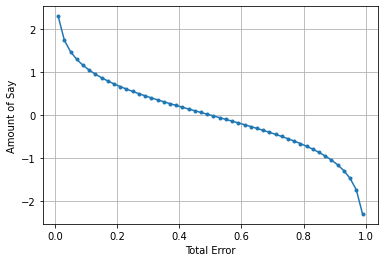

In [18]:
%matplotlib inline
te = np.linspace(0.01,0.99,num=50)
aos = amount_of_say(te)

ax = plt.subplot(111)
ax.plot(te,aos,'.-')

ax.set_xlabel("Total Error")
ax.set_ylabel("Amount of Say")

plt.grid()
plt.show()

It is visible from the graph that when total error is less, amount of say is high and when total error is high amount of say decreases.

lets say if the total error is 0.5(50-50), then amount of say is 0. that means this stump doesn't matter to the final results.

Amount of say of the stump

In [19]:
stump_aos = amount_of_say(total_error)
total_error, stump_aos

(0.375, 0.25541281188299536)

### Updating Sample weight

#### Increase sample weight for incorrectly classified samples

New Sample Weight = Sample Weight x $e^{\text{amount of say}}$

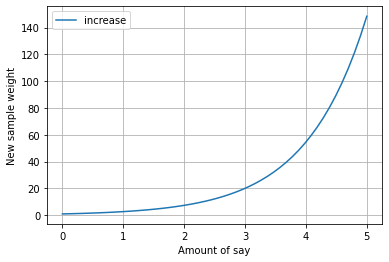

In [20]:

plt.plot(np.linspace(0,5,50),np.exp(np.linspace(0,5,50)), label="increase")
plt.xlabel("Amount of say")
plt.ylabel("New sample weight")
plt.legend()
plt.grid()

So the new sample weight will be little larger than the sample weight for the positive amount of say.

#### Decrease sample weight for correctly classified samples

New Sample Weight = Sample Weight x $e^{-\text{amount of say}}$

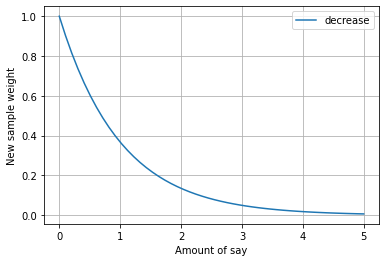

In [21]:
plt.plot(np.linspace(0,5,50),np.exp(-np.linspace(0,5,50)), label="decrease")
plt.xlabel("Amount of say")
plt.ylabel("New sample weight")
plt.legend()
plt.grid()

If amount of say of last stump was high then new sample weight will be close to zero or if amount of say of last stump was low then new sample weight will be close to 1.

In [22]:
def update_sample_weight(sample_weight, amount_of_say, increase=True):
    
    if increase:
        return sample_weight * np.exp(amount_of_say)
    else:
        return sample_weight * np.exp(-amount_of_say)

In [23]:
inc_class_weights = (predicted != y) * sample_weights
inc_class_weights

array([[0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.125],
       [0.   ],
       [0.125],
       [0.125]])

In [24]:
corr_class_weights = (predicted == y) * sample_weights
corr_class_weights

array([[0.125],
       [0.125],
       [0.125],
       [0.125],
       [0.   ],
       [0.125],
       [0.   ],
       [0.   ]])

In [25]:
new_inc_class_weights = update_sample_weight(inc_class_weights,stump_aos,increase=True)
new_inc_class_weights

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.16137431],
       [0.        ],
       [0.16137431],
       [0.16137431]])

In [26]:
new_corr_class_weights = update_sample_weight(corr_class_weights,stump_aos,increase=False)
new_corr_class_weights

array([[0.09682458],
       [0.09682458],
       [0.09682458],
       [0.09682458],
       [0.        ],
       [0.09682458],
       [0.        ],
       [0.        ]])

In [27]:
new_sample_weights = new_inc_class_weights + new_corr_class_weights

new_sample_weights

array([[0.09682458],
       [0.09682458],
       [0.09682458],
       [0.09682458],
       [0.16137431],
       [0.09682458],
       [0.16137431],
       [0.16137431]])

### Normalizing Sample Weights

After updating with new sample weights, these new sample weights need to be normalized so that when the are added up, sum will be 1(approx).
Now use these sample weights to create new stump.

In [28]:
new_sample_weights.sum()

0.9682458365518543

sum is not 1. lets make it(normalize)

In [29]:
new_sample_weights = new_sample_weights/ new_sample_weights.sum()

new_sample_weights

array([[0.1       ],
       [0.1       ],
       [0.1       ],
       [0.1       ],
       [0.16666667],
       [0.1       ],
       [0.16666667],
       [0.16666667]])

In [30]:
new_sample_weights.sum()

1.0


### Generating new samples

normally these new samples should be resampled and get mostly incorrected classified results from the previous sample

Generate empty matrix for new samples

In [32]:
new_sample_data = np.zeros_like(sample_data)
new_sample_data

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=object)

pickup samples from last samples

for this example we need mostly 4,6 and 7.

Numpy random choice with p(probabilities) gives us the random choice of indexes from the range.

In [120]:
idxs = np.random.choice(range(sample_data.shape[0]),size=(sample_data.shape[0],),p=new_sample_weights[...,-1])

idxs

array([7, 3, 3, 6, 4, 4, 2, 0])

In [123]:
new_sample_data = sample_data[idxs]
new_sample_data

array([['yes', 'yes', 172, 'no'],
       ['yes', 'yes', 167, 'yes'],
       ['yes', 'yes', 167, 'yes'],
       ['yes', 'no', 168, 'no'],
       ['no', 'yes', 156, 'no'],
       ['no', 'yes', 156, 'no'],
       ['yes', 'no', 210, 'yes'],
       ['yes', 'yes', 205, 'yes']], dtype=object)

In [125]:
X = new_sample_data[...,[0,1,2]]
y = new_sample_data[...,[-1]]
feature_name =headers[:-1]
target_name = headers[-1]

stump = DecisionTreeClassifier(max_depth=0)
stump.train(
    X=X,
    y=y,
    feature_name=feature_name,
    target_name=target_name
)

stump.print_tree()

|-Is Patient Weight >= 210 ? | gini :0.5
|---> True:
  |--  Predict : {'yes': 1}
|---> False:
  |--  Predict : {'no': 4, 'yes': 3}


## Gradient Boosting Regression